# Principal component analysis

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

This notebook illustates how to do principal component analysis in Python.

Here we implement it ourselves from scratch just to illustrate. In practice you can use scikit learn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class.

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

## Data generation

Let's start by writing a function to generate some random 2D data that lies close to a linear manifold. To achieve this, we generate some bivariate normal samples with more variance along the x-axis than the y-axis. We can then rotate these samples (by multiplying by a rotation matrix) to rotate the manifold

In [ ]:
def make_data(n=50):
    """Generates some random data that is on a linear manifold"""
    x1 = np.random.randn(n) * 10
    x2 = np.random.randn(n) 
    X = np.c_[x1, x2]
    theta = np.deg2rad(45)
    R = np.array([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])
    X = np.dot(X, R)
    return X

Now lets generate 100 samples and scatterplot them.

(-16.9566918548803, 18.51384446310982, -17.32269919296896, 18.873259189041843)

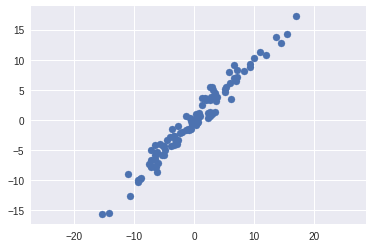

In [ ]:
# generate and plot some data
X = make_data(100)
scatter(X[:, 0], X[:, 1])
axis('equal')

## PCA implementation

We implement PCA using a class that roughly follows scikit-learn's interfaces (i.e. by implementing methods like `fit` and `transform`).

The `fit` function finds the eigenvalues and eigenvectors of the emperical covariance matrix and stores the top-n of these. The ``transform`` method subtracts the data mean and projects onto the eigenvector basis. `ìnverse_transform` tries to reconstruct the original data by undoing the rotation done by `transform`.

**Note**: You can also implement PCA without needing to explicitly calculate the covariance matrix using the singular value decomposition (SVD). See the [notes on PCA](https://loop.dcu.ie/mod/resource/view.php?id=740814) for more details.

In [ ]:
class PCA(object):
    """Implementation of PCA"""
    
    def __init__(self, n=1):
        self.n = n
        
    def fit(self, X):
        
        # compute mean of the data and store
        self.mean = X.mean(axis=0)
        
        # subtract the mean
        X = X - self.mean
        
        # compute the emperical covariance matrix
        covariance = np.dot(X.T, X)
        
        # compute eigenvalues and eigenvectors
        vals, vecs = np.linalg.eig(covariance)
        
        # sort eigenvalues and vectors by eigenvalue
        indices = np.argsort(-vals)
        vals = vals[indices]
        vecs = vecs[:, indices]
        
        # store mean, eigenvalues, and principal components
        self.eigenvalues = vals
        self.components = vecs[:, :self.n]
        return self
        
    def transform(self, X):
        return np.dot(X - self.mean, self.components)

    def inverse_transform(self, X):
        return np.dot(X, self.components.T) + self.mean

## Fit the PCA

We can now call `fit` on our generated data to compute the largest eigenvalue and eigenvector (we're projecting onto a single dimension)

In [ ]:
pca = PCA(1)
pca.fit(X)

## Transform the sample

Transform our generated data so that it is univariate. The resulting data lies on the x-axis.

(100, 1)


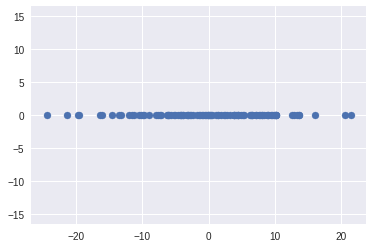

In [ ]:
X_pca = pca.transform(X)

scatter(X_pca, np.zeros(X_pca.shape[0]))
axis('equal')

print(X_pca.shape)

## Reconstruct

Reconstruct the 2D data from the 1D PCA transformed data and compare with the original data.

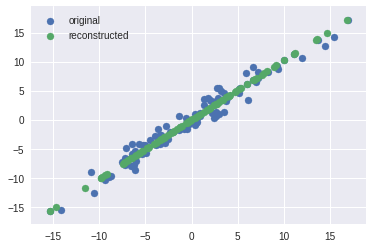

In [ ]:
X_reconstructed = pca.inverse_transform(X_pca)
scatter(X[:,0], X[:,1], label='original')
scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], label='reconstructed')
legend()

## Using PCA to do dimensionality reduction for visualization

PCA is often used for visualizing high-dimensional data in two dimensions. Here we look at reducing the dimensionality of the 4D Iris dataset so that we can scatterplot the observations. 


In [ ]:
from sklearn.datasets import load_iris

Load the dataset and print the feature names and classes

In [ ]:
dataset = load_iris()

X = dataset.data
y = dataset.target

print(dataset['target_names'])
print(dataset['feature_names'])
print(X.shape)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
(150, 4)


Use PCA to reduce dimensionality to 2

In [ ]:
pca = PCA(2)
pca.fit(X)
X_pca = pca.transform(X)

Scatterplot the results

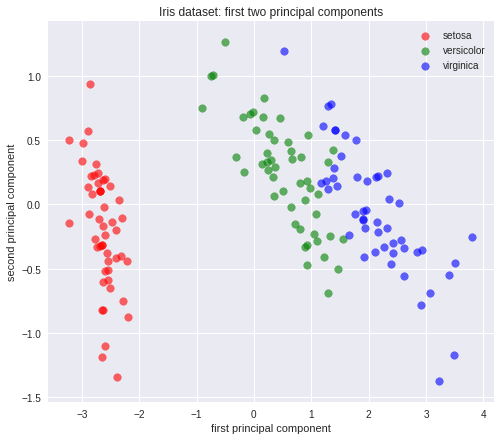

In [ ]:
figure(figsize=(8,7))
for c, i, target_name in zip("rgb", [0, 1, 2], dataset['target_names']):
    scatter(X_pca[y == i, 0], X_pca[y == i, 1], c=c, s=60, alpha=0.6, label=target_name)
xlabel('first principal component')
ylabel('second principal component')
legend(dataset['target_names'])
title('Iris dataset: first two principal components')
show()

Plot the eigenvalues from largest to smallest.

Text(0,0.5,u'eigenvalue')

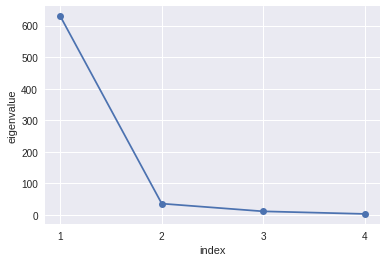

In [ ]:
plot(range(1, 5), pca.eigenvalues, 'o-')
xticks([1,2,3,4])
xlabel('index')
ylabel('eigenvalue')

## Looking at the total explained variance

Here we look at total explained variance on a [dataset of solar flare activity](http://mlbench.org/repository/data/viewslug/flare-solar-ida/).

In [ ]:
from sklearn.datasets import fetch_mldata
dataset = fetch_mldata('Flare Solar IDA')
X = dataset.data

The dataset has 144 9-dimensional observations.

In [ ]:
print(X.shape)

(144, 9)


Again, we fit a 2D PCA to reduce the dimensionality from 9 to 2.

In [ ]:
pca = PCA(2)
pca.fit(X)

Now we can look at the fraction of variance explained by the top-n eigenvectors. We see we would need just 4 dimensions to capture >85% of the variance.

Text(0,0.5,u'total explained variance')

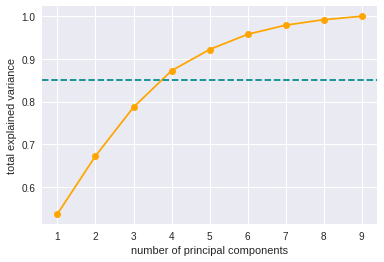

In [ ]:
total_variance = pca.eigenvalues.sum()
v = pca.eigenvalues / total_variance

plot(np.arange(1, len(v)+1), np.cumsum(v), 'o-', color='orange')
axhline(0.85, ls='dashed', color='darkcyan')
xlabel('number of principal components')
ylabel('total explained variance')

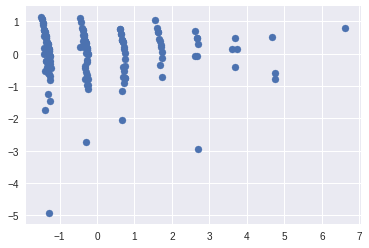

In [ ]:
X_pca = pca.transform(X)
scatter(X_pca[:, 0], X_pca[:, 1])